# Video analysis


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

## 3. Analysis

### 3.1 LLM caller 정의

In [7]:
from textwrap import dedent
from utils.bedrock import bedrock_utils, bedrock_chain

class llm_call():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.verbose = kwargs.get("verbose", False)
        self.chain = bedrock_chain(bedrock_utils.converse_api) | bedrock_chain(bedrock_utils.outputparser)

    def _message_format(self, role, message):

        if role == "user":
             message_format = {
                "role": "user",
                "content": [{"text": dedent(message)}]
            }
        elif role == "assistant":
            
            message_format = {
                "role": "assistant",
                'content': [{'text': dedent(message)}]
            }

        return message_format
            
    def invoke(self, **kwargs):

        system_prompts = kwargs.get("system_prompts", None)
        messages = kwargs["messages"]
        #llm_name = kwargs["llm_name"]
    
        response = self.chain( ## pipeline의 제일 처음 func의 argument를 입력으로 한다. 여기서는 converse_api의 arg를 쓴다.
            llm=self.llm,
            system_prompts=system_prompts,
            messages=messages,
            verbose=self.verbose
        )
        
        ai_message = self._message_format(role="assistant", message=response["text"])
        messages.append(ai_message)
        return response, messages

### 3.2 Timer 정의

In [8]:
import time

In [9]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

### 3.3 Video analyzer 정의

In [10]:
import cv2
import shutil
import pickle
import botocore

from pathlib import Path
from pprint import pprint
from typing import TypedDict, Any
import matplotlib.pyplot as plt
from utils.common_utils import retry
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

In [11]:
class GraphState(TypedDict):
    video_path: str
    video_info: dict
    analysis_config: dict
    summary:str
    target_apps: list[str]
    ask_refo: str
    code: str
    code_err: str
    img_path: str
    img_bytes: str
    chart_desc: str
    prev_node: str

- **approach 1**: 각각의 프레임에 대한 desc를 생성한 후, 생성된 desc를 모아서 요약하여 상황설명 한다.

In [12]:
class video_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=True ## To show token usage
        ) 

        self._graph_definition()
        self.messages = []
        self.img_bytes = ""
        
        self.timer = TimeMeasurement()
        
    def _get_price(self, tokens):
        
        input_price = tokens["input"] * 0.003 / 1000
        output_price = tokens["output"] * 0.015 / 1000
        total = input_price + output_price
        
        print ("======= Cost Calculator =======")
        print (f'Token Usage, input: {tokens["input"]}, Output: {tokens["output"]}')
        print (f'Price: {total} USD')
        print ("===============================")
        
    def _get_string_from_message(self, message):
        return message["content"][0]["text"]
    
    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": [{"text": dedent(string)}]
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)

        return message
        
    def _frame_to_bytes(self, frame, format='.png'):
        """
        cv2 frame을 bytes로 변환

        Args:
            frame: cv2로 읽은 이미지/프레임
            format: 이미지 포맷 (예: '.jpg', '.png')

        Returns:
            bytes: 이미지의 바이트 데이터
        """
        # imencode() 함수로 프레임을 지정된 포맷의 이미지로 인코딩
        # 반환값: (success, encoded_image)
        success, buffer = cv2.imencode(format, frame)

        if not success:
            raise ValueError("이미지 인코딩 실패")

        # numpy array를 bytes로 변환
        return buffer.tobytes()

    def _save_pickle(self, data: Any, file_path: str | Path) -> None:
        """
        데이터를 pickle 파일로 저장합니다.

        Args:
            data: 저장할 데이터 (Any type)
            file_path: 저장할 파일 경로 (확장자 .pkl 권장)
        """
        file_path = Path(file_path)

        # 디렉토리가 없으면 생성
        file_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with open(file_path, 'wb') as f:
                pickle.dump(data, f)
            print(f"Successfully saved to {file_path}")
        except Exception as e:
            print(f"Error saving pickle file: {e}")

    def _load_pickle(self, file_path: str | Path) -> Any:
        """
        pickle 파일을 로드합니다.

        Args:
            file_path: 로드할 파일 경로

        Returns:
            저장된 데이터 객체

        Raises:
            FileNotFoundError: 파일이 존재하지 않을 경우
        """
        file_path = Path(file_path)

        if not file_path.exists():
            raise FileNotFoundError(f"No pickle file found at {file_path}")

        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            return data
        except Exception as e:
            print(f"Error loading pickle file: {e}")
            return None

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):
        
        def agent(state):
            
            self.timer.start()
            self.timer.reset()
            
            print("---CALL AGENT---")
            video_path = state["video_path"]
            analysis_config = state["analysis_config"]
            
            self.tokens = {"input": 0, "output": 0, "total": 0}
            self.pricing = {"input": 0, "output": 0}
            
            print (analysis_config)
 
            return self.state(
                video_path=video_path,
                analysis_config=analysis_config,
                rev_node="AGENT"
            )

        def sample_video_frames(state):
            
            def setup_directory(dir_path):
    
                print ("===setup_directory===")
                # 디렉토리가 존재하는지 확인
                if os.path.exists(dir_path):
                    # 존재하면 삭제
                    shutil.rmtree(dir_path)
                    print(f"기존 디렉토리 삭제됨: {dir_path}")

                # 디렉토리 생성
                os.makedirs(dir_path)
                print(f"디렉토리 생성됨: {dir_path}")
                print ("=====================")
    
            
            print("---SAMPLE VIDEO FRAMES---")
            
            video_path = state["video_path"]
            sample_msec = state["analysis_config"]["sample_msec"]
            resize_ratio = state["analysis_config"]["resize_ratio"]
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            
            print ("===sample_video_frames===")
            """
            비디오에서 특정 시간 간격으로 프레임을 샘플링하는 함수

            Args:
                video_path (str): 비디오 파일 경로
                sample_msec (int): 샘플링 간격 (밀리초)
                sample_output_dir (Optional[str]): 프레임 저장 디렉토리. None이면 저장하지 않음

            Returns:
                Tuple[int, int]: (총 프레임 수, 샘플링된 프레임 수)

            Raises:
                FileNotFoundError: 비디오 파일이 없는 경우
                ValueError: 샘플링 간격이 잘못된 경우
            """
            # 입력값 검증
            if not os.path.exists(video_path):
                raise FileNotFoundError(f"비디오 파일을 찾을 수 없습니다: {video_path}")

            if sample_msec <= 0:
                raise ValueError("샘플링 간격은 0보다 커야 합니다")

            # 비디오 캡처 객체 생성
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise RuntimeError("비디오 파일을 열 수 없습니다")

            # 비디오 정보 가져오기
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # 샘플링 간격(프레임 단위) 계산
            frame_interval = max(1, int(sample_msec / 1000 * fps))

            # 출력 디렉토리 생성 (지정된 경우)
            if sample_output_dir is not None:
                setup_directory(sample_output_dir)

            sampled_count = 0
            frame_count = 0
            sampled_frame = {"frame": [], "seq": []}

            while True:
                ret, frame = cap.read()
                if not ret: break
                
                # resize
                if resize_ratio != 1:
                    re_width, re_height = int(frame.shape[1]*resize_ratio), int(frame.shape[0]*resize_ratio)
                    frame = cv2.resize(frame, (re_width, re_height), interpolation=cv2.INTER_AREA)

                # frame_interval마다 프레임 처리
                if frame_count % frame_interval == 0:
                    if sample_output_dir is not None:
                        # 프레임 저장
                        frame_path = os.path.join(sample_output_dir, f"frame_{frame_count:06d}.jpg")
                        cv2.imwrite(frame_path, frame)
                    sampled_count += 1
                    sampled_frame["frame"].append(frame)
                    sampled_frame["seq"].append(frame_count)
                frame_count += 1

                # 진행상황 출력 (10% 단위)
                if frame_count % (total_frames // 10) == 0:
                    progress = (frame_count / total_frames) * 100
                    print(f"진행률: {progress:.1f}%")

            # 자원 해제
            cap.release()

            print(f"\n처리 완료:")
            print(f"총 프레임 수: {total_frames}")
            print(f"프레임 크기: {sampled_frame['frame'][0].shape[1]}X{sampled_frame['frame'][0].shape[0]}")
            print(f"샘플링된 프레임 수: {sampled_count}")
            print(f"샘플링 간격: {frame_interval}프레임 ({sample_msec}ms)")
            if sample_output_dir is not None:
                print(f"저장 위치: {sample_output_dir}")

            print ("=========================")
            
            sampled_frames_path = os.path.join(sample_output_dir, "pickle", "sampled_frames.pickle")
            self._save_pickle(sampled_frame, sampled_frames_path)
            
            video_info = {
                "sampled_frames_path": sampled_frames_path,
                "total_frame_cnt": total_frames,
                "sampled_cnt": sampled_count
            }
            
            self.timer.measure("node: sample_video_frames")
            self.timer.print_measurements()
            
            return self.state(
                video_info=video_info,
                rev_node="SAMPLE_VIDEO_FRAMES"
            )
        
        def video_description(state):
            
            @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
            def frame_description(**kwargs):

                sampled_frame = kwargs["sampled_frame"]
                sampled_frame_idx = kwargs["sampled_frame_idx"]
                total_frame_cnt = kwargs["total_frame_cnt"]
                prev_frame_desc = kwargs.get("prev_frame_desc", "None")
                messages = kwargs["messages"] 

                system_prompts = dedent(
                    '''
                    당신은 CCTV 영상 분석 전문가입니다.
                    주어진 CCTV 프레임 이미지를 분석하고 자연어로 상황을 설명하는 것이 당신의 임무입니다.

                    <task>
                    CCTV 프레임 이미지를 관찰하고 해당 장면에서 발생하는 상황을 자연어로 설명
                    </task>

                    <input>
                    1. frame: CCTV에서 캡처된 단일 프레임 이미지
                    2. frame_info: 
                       - frame_number: 전체 시퀀스에서 현재 프레임의 순서
                       - total_frame_number: 전체 프레임 수
                       - prev_frame_desc: 이전 프레임 설명
                    </input>

                    <output_format>
                    {
                        "scene_description": "현재 프레임에서 관찰되는 상황에 대한 객관적 설명",
                        "person_description": "움직이는 사람의 경우, 그 사람을 인식/구분하기 위한 특징 설명"
                    }
                    </output_format>

                    <instruction>
                    1. 주어진 프레임을 객관적으로 관찰하세요.
                    2. 이전 프레임 설명을 고려하여 현재 프레임을 관찰하세요.
                    3. 움직이는 물체나 사람들의 활동을 식별하세요.
                    4. 움직임이 없는 물체/사람에 대해서는 설명하지 마세요.
                    5. 주변 사물에 대해서는 설명하지 마세요.
                    6. 특이사항이나 중요한 변화가 있다면 이를 강조하세요.
                    7. 추측이나 주관적 해석은 최소화하고 관찰 가능한 사실만 설명하세요.
                    8. 설명은 간결하고 명확하게 작성하세요.
                    9. 설명은 한글로 작성하세요.
                    </instruction>

                    <consideration>

                    1. 사람이나 물체의 위치 변화에 특히 주의를 기울이세요.
                    2. 시야가 가려지거나 불명확한 부분이 있다면 이를 명시하세요.
                    3. 여러 물체나 사람이 있는 경우, 각각을 구분하여 설명하세요.
                    4. 비정상적이거나 특이한 활동이 관찰되면 이를 강조하세요.
                    5. 조명 상태나 화질로 인한 제약사항이 있다면 이를 언급하세요.
                    </consideration>

                    '''
                )
                user_prompts = dedent(
                    '''
                    This is <frame_number>{frame_number}</frame_number>
                    This is <total_frame_number>{total_frame_number}</total_frame_number>
                    This is <prev_frame_desc>{prev_frame_desc}</prev_frame_desc>
                    This is the frame.

                    '''
                )

                img_bytes = self._frame_to_bytes(sampled_frame)
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

                context = {
                    "frame_number": sampled_frame_idx,
                    "total_frame_number": total_frame_cnt,
                    "prev_frame_desc": prev_frame_desc
                }
                user_prompts = user_prompts.format(**context)

                message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
                messages.append(message)
                
                 # 이미지 표시
                rgb_frame = cv2.cvtColor(sampled_frame, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 6))
                plt.imshow(rgb_frame)
                plt.axis('off')  # 축 숨기기
                plt.show()
                
                # Call LLM
                resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                
                if self.llm_caller.verbose:
                    self.tokens["input"] += resp["token_usage"]["inputTokens"]
                    self.tokens["output"] += resp["token_usage"]["outputTokens"]
                    self.tokens["total"] += resp["token_usage"]["totalTokens"]
                    print (f'total token usage: {self.tokens}')    
                
                messages = messages_updated
                results = eval(resp["text"])

                return results
            
            print("---VIDEO DESCRIPTION---")
            sampled_frames= self._load_pickle(state["video_info"]["sampled_frames_path"])
            total_frame_cnt=state["video_info"]["total_frame_cnt"]
            messages=kwargs.get("messages", [])

            frame_desc = "None"
            frame_descs = []
            for sampled_frame_idx, sampled_frame in zip(sampled_frames["seq"], sampled_frames["frame"]):

                res = frame_description(
                    sampled_frame=sampled_frame,
                    sampled_frame_idx=sampled_frame_idx,
                    total_frame_cnt=total_frame_cnt,
                    frame_desc=frame_desc,
                    messages=[]
                )
                frame_desc = res["scene_description"]
                frame_descs.append([res["scene_description"], res["person_description"]])

            system_prompts = dedent(
                '''
                당신은 CCTV 영상의 전체 상황을 분석하는 전문가입니다.
                개별 프레임 설명들을 종합하여 전체 시퀀스에서 발생한 상황을 요약하고 의미있는 이벤트를 추출하는 것이 당신의 임무입니다.

                <task>
                시간 순서대로 정렬된 프레임별 설명을 분석하여 전체 상황을 요약하고 중요 이벤트를 추출
                </task>

                <input>
                - frame_descriptions: 각 프레임별 설명 ([상황 설명, 움직이는 사람 설명])이 담긴 텍스트형태의 리스트
                </input>

                <output_format>
                {
                   "summary": "전체 시퀀스에서 발생한 상황에 대한 종합적 설명",
                   "key_events": [
                       {
                           "description": "이벤트 설명",
                           "significance": "이벤트의 중요도 (HIGH/MEDIUM/LOW)"
                       }
                   ],
                   "objects_involved": {
                       "people": ["식별된 사람 수 및 역할"],
                       "items": ["관련된 주요 물체들"]
                   },
                   "analysis": {
                       "pattern": "발견된 행동 패턴",
                       "anomalies": ["비정상적인 활동이나 특이사항"],
                       "risk_assessment": "잠재적 위험 평가"
                   }
                }
                </output_format>

                <instruction>
                1. 개별 프레임 설명들을 시간순으로 검토하여 전체 맥락을 파악하세요.
                2. 전체적인 맥락을 고려하여 프레임 설명이 잘못되어 있다면 수정하여 결과에 반영하세요.
                3. 프레임 설명은 하나의 상황을 반영하고 있음을 인지하세요.
                4. 연속된 프레임들에서 의미있는 이벤트를 식별하세요.
                5. 이벤트의 중요도를 평가할 때는 다음을 고려하세요:
                  - 보안상의 위험성
                  - 비정상적인 행동 패턴
                  - 시설물이나 재산에 대한 위험
                6. 전체 상황에서 패턴이나 특이사항을 분석하세요.
                7. 설명은 간결하고 객관적으로 작성하세요.
                8. 설명은 한글로 작성하세요.
                </instruction>

                <consideration>
                1. 단순한 움직임이나 일상적인 활동은 중요 이벤트에서 제외하세요.
                2. 동일한 이벤트가 반복되는 경우 패턴으로 분류하세요.
                3. 시간대별 일반적인 활동 패턴과 비교하여 이상 징후를 판단하세요.
                4. 보안과 프라이버시를 고려하여 개인을 특정할 수 있는 정보는 제외하세요.
                5. 불확실한 상황에 대해서는 추측을 피하고 관찰된 사실만 보고하세요.
                6. 잠재적 위험이 감지되면 이를 반드시 포함하세요.
                7. 전체 맥락에서 중요하지 않은 세부사항은 생략하세요.
                8. 움직이는 사람 설명을 바탕으로 frame에 등장하는 사람의 동일인 여부를 판단하세요.
                </consideration>
                '''
            )
            user_prompts = dedent(
                '''
                This is <frame_descriptions>{frame_descriptions}</frame_descriptions>

                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

            context = {
                "frame_descriptions": str(frame_descs)
            }
            user_prompts = user_prompts.format(**context)

            message = self._get_message_from_string(role="user", string=user_prompts)
            messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            
            if self.llm_caller.verbose:
                self.tokens["input"] += resp["token_usage"]["inputTokens"]
                self.tokens["output"] += resp["token_usage"]["outputTokens"]
                self.tokens["total"] += resp["token_usage"]["totalTokens"]            
                self._get_price(self.tokens)
                
            messages = messages_updated
            results = eval(resp["text"])
            
            self.timer.measure("node: video_description")
            self.timer.print_measurements()
            
            return self.state(
                summary=results,
                rev_node="VIDEO_DESCRIPTION"
            )
        
        def cleanup(state):
                        
            print("---CLEAN UP---")
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            if os.path.exists(sample_output_dir):
                # 존재하면 삭제
                shutil.rmtree(sample_output_dir)
                print(f"디렉토리 삭제됨: {sample_output_dir}")
                        
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
        workflow.add_node("sample_video_frames", sample_video_frames)  # 비디오를 샘플링하여 프레임(이미지)변환 노드를 추가합니다.
        workflow.add_node("video_description", video_description)  # 비디오 영상 설명 노드를 추가합니다.
        workflow.add_node("cleanup", cleanup)  # 정리 노드를 추가합니다.

        workflow.add_edge("agent", "sample_video_frames")
        workflow.add_edge("sample_video_frames", "video_description")
        workflow.add_edge("video_description", "cleanup")
        workflow.add_edge("cleanup", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("agent")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "VideoAnalysis"})

    def invoke(self, **kwargs):
        
        inputs = self.state(
            video_path=kwargs["video_path"],
            analysis_config=kwargs["analysis_config"]
        )
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint(f"\nOutput from node '{key}':")
                pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [13]:
analyzer = video_analyzer(
    llm=llm
)

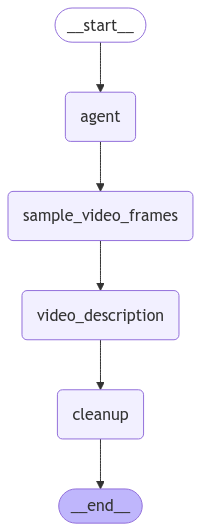

In [14]:
analyzer.show_graph()

---CALL AGENT---
{'sample_msec': 10000, 'resize_ratio': 0.7, 'sample_output_dir': './workspace'}
"\nOutput from node 'agent':"
'---'
{ 'analysis_config': { 'resize_ratio': 0.7,
                       'sample_msec': 10000,
                       'sample_output_dir': './workspace'},
  'video_path': './video/video_sample_2.mkv'}
'\n---\n'
---SAMPLE VIDEO FRAMES---
===sample_video_frames===
===setup_directory===
기존 디렉토리 삭제됨: ./workspace
디렉토리 생성됨: ./workspace
진행률: 10.0%
진행률: 20.0%
진행률: 30.0%
진행률: 39.9%
진행률: 49.9%
진행률: 59.9%
진행률: 69.9%
진행률: 79.9%
진행률: 89.9%


INFO:retry-bedrock-invocation:trying frame_description() [1/5]



처리 완료:
총 프레임 수: 4677
프레임 크기: 448X336
샘플링된 프레임 수: 16
샘플링 간격: 303프레임 (10000ms)
저장 위치: ./workspace
Successfully saved to workspace/pickle/sampled_frames.pickle

elapsed time: node: sample_video_frames: 5.84413 초
"\nOutput from node 'sample_video_frames':"
'---'
{ 'video_info': { 'sampled_cnt': 16,
                  'sampled_frames_path': './workspace/pickle/sampled_frames.pickle',
                  'total_frame_cnt': 4677}}
'\n---\n'
---VIDEO DESCRIPTION---


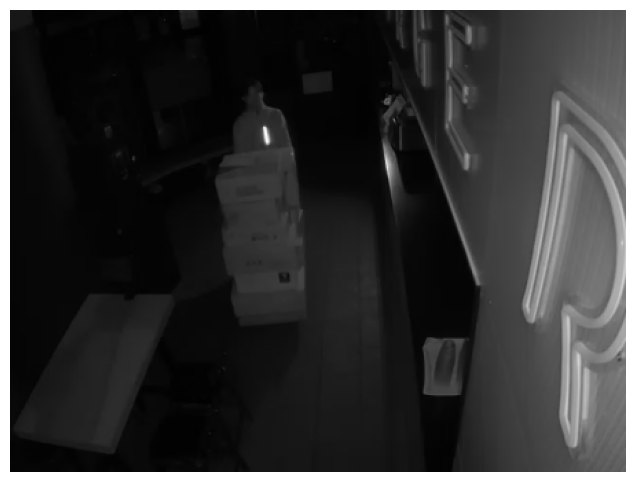


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 한 사람이 이동하는 모습이 포착되었습니다. 해당 인물은 복도나 통로로 보이는 공간을 걸어가고 있습니다.",
    "person_description": "해당 인물은 전신이 보이며, 어두운 조명 조건으로 인해 자세한 특징은 식별하기 어렵습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 한 사람이 이동하는 모습이 포착되었습니다. 해당 인물은 복도나 통로로 보이는 공간을 걸어가고 있습니다.', 'person_description': '해당 인물은 전신이 보이며, 어두운 조명 조건으로 인해 자세한 특징은 식별하기 어렵습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1048
Output tokens: 142
Total tokens: 1190
Latency: 4600 milliseconds
total token usage: {'input': 1048, 'output': 142, 'total': 1190}


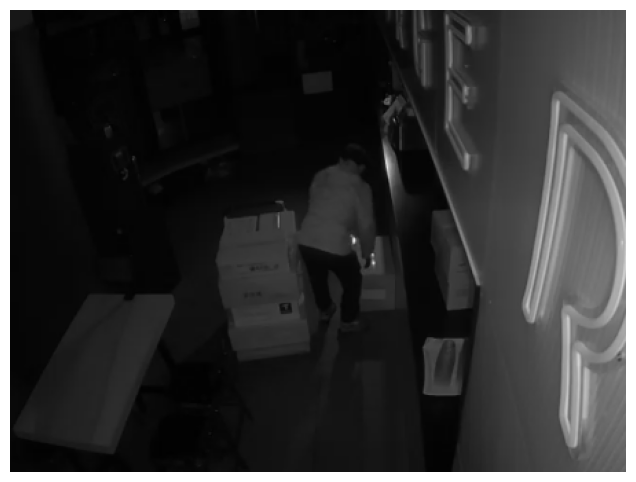


Role: assistant
{
    "scene_description": "실내 공간에서 한 사람이 바닥에 놓인 여러 개의 상자들 사이에서 몸을 숙이고 있는 모습이 보입니다. 영상은 흑백 CCTV로 촬영되었습니다.",
    "person_description": "한 사람이 상의를 입고 있으며, 몸을 앞으로 구부린 자세를 취하고 있습니다. 바닥에 놓인 물건들을 향해 몸을 기울이고 있는 것으로 보입니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 한 사람이 바닥에 놓인 여러 개의 상자들 사이에서 몸을 숙이고 있는 모습이 보입니다. 영상은 흑백 CCTV로 촬영되었습니다.', 'person_description': '한 사람이 상의를 입고 있으며, 몸을 앞으로 구부린 자세를 취하고 있습니다. 바닥에 놓인 물건들을 향해 몸을 기울이고 있는 것으로 보입니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1048
Output tokens: 188
Total tokens: 1236
Latency: 5837 milliseconds
total token usage: {'input': 2096, 'output': 330, 'total': 2426}


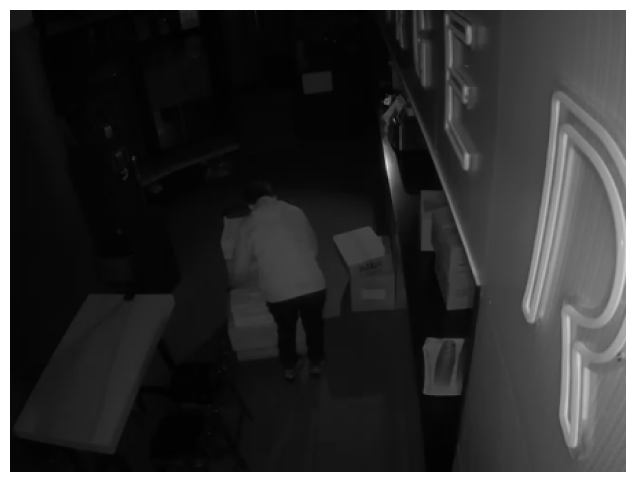


Role: assistant
{
    "scene_description": "실내 공간에서 한 사람이 몸을 숙인 자세로 서 있는 모습이 보입니다. 흑백 CCTV 영상으로, 공간이 어둡게 보입니다.",
    "person_description": "긴 상의를 입은 사람이 앞으로 몸을 숙인 자세를 취하고 있습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 한 사람이 몸을 숙인 자세로 서 있는 모습이 보입니다. 흑백 CCTV 영상으로, 공간이 어둡게 보입니다.', 'person_description': '긴 상의를 입은 사람이 앞으로 몸을 숙인 자세를 취하고 있습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1048
Output tokens: 131
Total tokens: 1179
Latency: 4425 milliseconds
total token usage: {'input': 3144, 'output': 461, 'total': 3605}


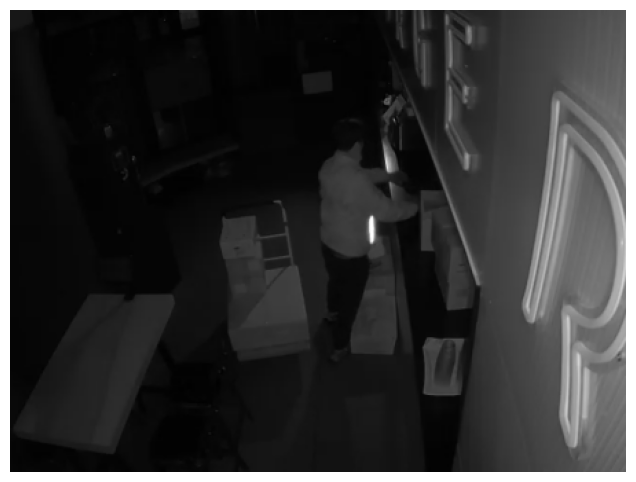


Role: assistant
{
    "scene_description": "실내 공간에서 한 사람이 서서 무언가를 살펴보거나 작업하는 모습이 포착되었습니다. 화면은 흑백 CCTV 영상으로 촬영되었으며, 주변에 여러 박스나 물품들이 놓여있는 것이 보입니다.",
    "person_description": "한 명의 사람이 서 있으며, 어두운 상의를 입고 있습니다. 해당 인물은 무언가를 자세히 보거나 조작하는 듯한 자세를 취하고 있습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 한 사람이 서서 무언가를 살펴보거나 작업하는 모습이 포착되었습니다. 화면은 흑백 CCTV 영상으로 촬영되었으며, 주변에 여러 박스나 물품들이 놓여있는 것이 보입니다.', 'person_description': '한 명의 사람이 서 있으며, 어두운 상의를 입고 있습니다. 해당 인물은 무언가를 자세히 보거나 조작하는 듯한 자세를 취하고 있습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1048
Output tokens: 201
Total tokens: 1249
Latency: 5603 milliseconds
total token usage: {'input': 4192, 'output': 662, 'total': 4854}


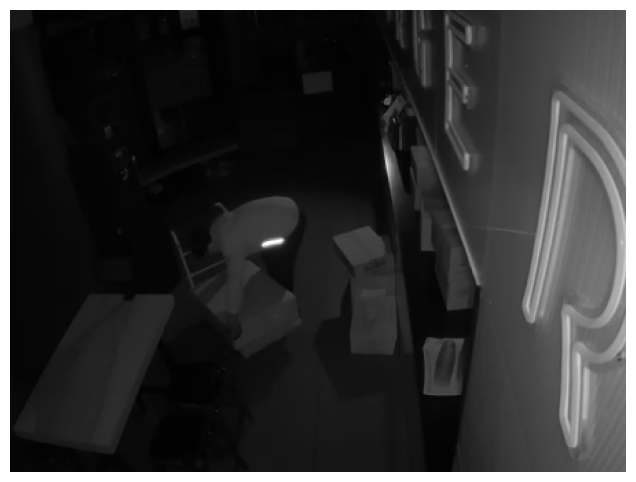


Role: assistant
{
    "scene_description": "실내 공간에서 한 사람이 몸을 숙인 자세로 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 CCTV로 촬영된 흑백 영상입니다.",
    "person_description": "해당 인물은 몸을 구부린 자세로 있으며, 정확한 신체 특징을 파악하기는 어렵습니다. 어두운 환경으로 인해 의상이나 기타 특징을 명확히 식별하기 어려운 상황입니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 한 사람이 몸을 숙인 자세로 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 CCTV로 촬영된 흑백 영상입니다.', 'person_description': '해당 인물은 몸을 구부린 자세로 있으며, 정확한 신체 특징을 파악하기는 어렵습니다. 어두운 환경으로 인해 의상이나 기타 특징을 명확히 식별하기 어려운 상황입니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 191
Total tokens: 1240
Latency: 5126 milliseconds
total token usage: {'input': 5241, 'output': 853, 'total': 6094}


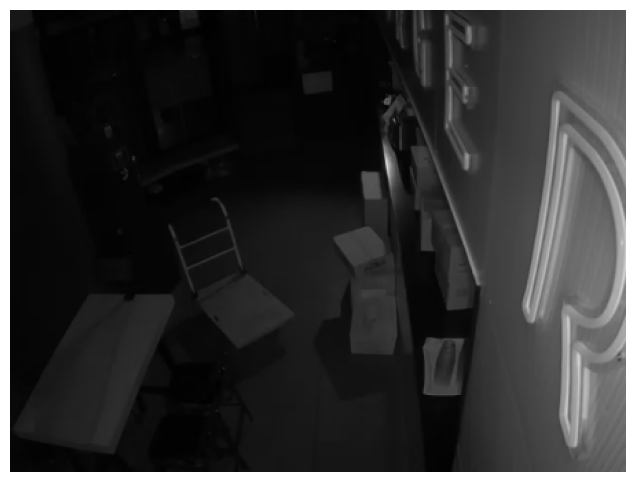


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 한 사람이 벽면 쪽에서 움직이는 모습이 포착되었습니다. 공간에는 여러 박스들과 의자가 놓여있는 것이 보입니다.",
    "person_description": "벽면 근처에서 움직이는 한 명의 사람이 관찰됩니다. 어두운 조명 조건으로 인해 자세한 특징은 식별하기 어렵습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 한 사람이 벽면 쪽에서 움직이는 모습이 포착되었습니다. 공간에는 여러 박스들과 의자가 놓여있는 것이 보입니다.', 'person_description': '벽면 근처에서 움직이는 한 명의 사람이 관찰됩니다. 어두운 조명 조건으로 인해 자세한 특징은 식별하기 어렵습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 166
Total tokens: 1215
Latency: 5161 milliseconds
total token usage: {'input': 6290, 'output': 1019, 'total': 7309}


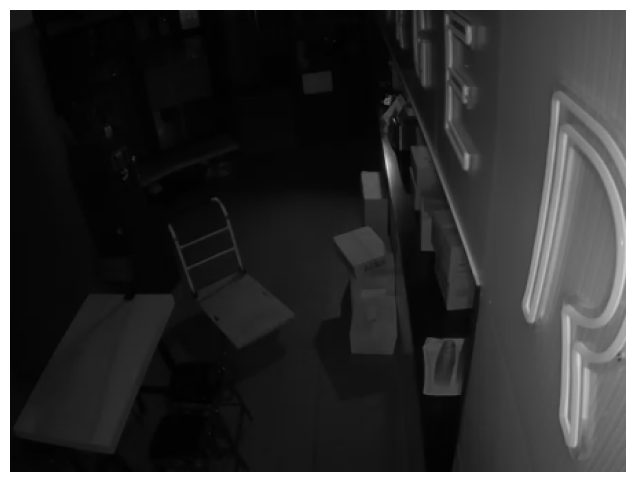


Role: assistant
{
    "scene_description": "실내 공간에서 의자가 넘어져 있고, 여러 개의 상자나 물건들이 바닥에 흩어져 있는 모습이 관찰됩니다. 공간이 어둡고 조명이 충분하지 않아 세부적인 상황 파악이 제한적입니다.",
    "person_description": "현재 프레임에서 움직이는 사람은 관찰되지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 의자가 넘어져 있고, 여러 개의 상자나 물건들이 바닥에 흩어져 있는 모습이 관찰됩니다. 공간이 어둡고 조명이 충분하지 않아 세부적인 상황 파악이 제한적입니다.', 'person_description': '현재 프레임에서 움직이는 사람은 관찰되지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 152
Total tokens: 1201
Latency: 4261 milliseconds
total token usage: {'input': 7339, 'output': 1171, 'total': 8510}


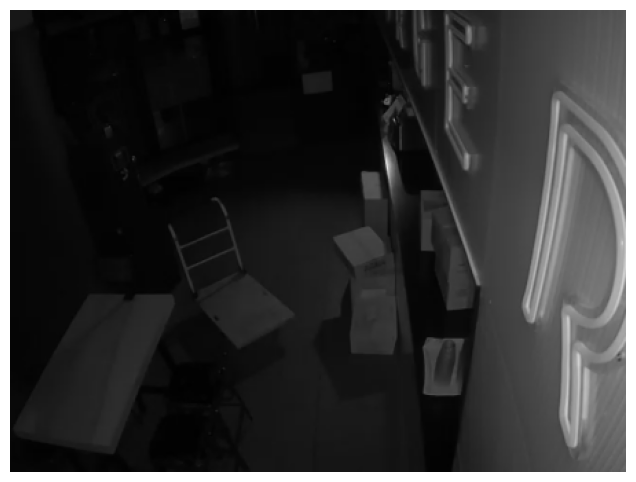


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 의자와 여러 개의 상자들이 놓여있는 모습이 보입니다. 현재 프레임에서는 특별한 움직임이나 활동이 관찰되지 않습니다.",
    "person_description": "프레임 내에서 사람의 움직임은 관찰되지 않습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 의자와 여러 개의 상자들이 놓여있는 모습이 보입니다. 현재 프레임에서는 특별한 움직임이나 활동이 관찰되지 않습니다.', 'person_description': '프레임 내에서 사람의 움직임은 관찰되지 않습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 127
Total tokens: 1176
Latency: 3563 milliseconds
total token usage: {'input': 8388, 'output': 1298, 'total': 9686}


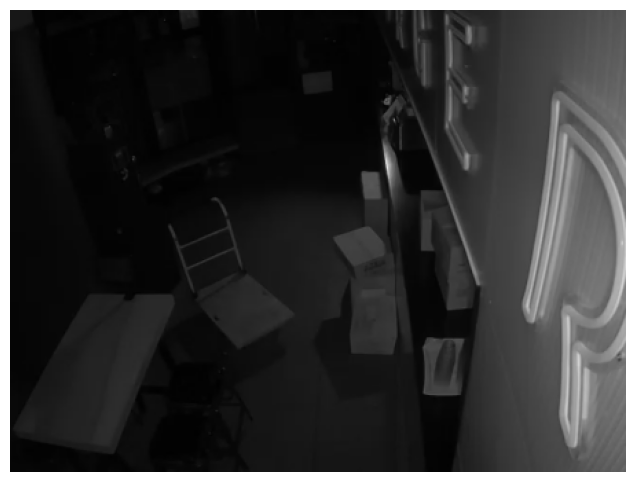


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 한 사람이 움직이고 있습니다. 공간에는 여러 개의 상자나 물체들이 흩어져 있는 것으로 보입니다.",
    "person_description": "어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기는 어렵지만, 실내를 이동하는 한 명의 인물이 관찰됩니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 한 사람이 움직이고 있습니다. 공간에는 여러 개의 상자나 물체들이 흩어져 있는 것으로 보입니다.', 'person_description': '어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기는 어렵지만, 실내를 이동하는 한 명의 인물이 관찰됩니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 153
Total tokens: 1202
Latency: 4461 milliseconds
total token usage: {'input': 9437, 'output': 1451, 'total': 10888}


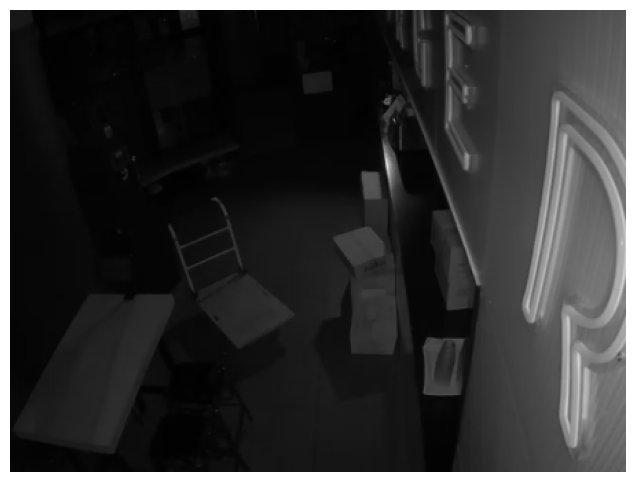


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 한 사람이 움직이고 있습니다. 공간에는 의자와 여러 개의 상자들이 놓여있는 것이 보입니다.",
    "person_description": "어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기는 어렵지만, 한 명의 인물이 공간 내에서 움직임이 포착됩니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 한 사람이 움직이고 있습니다. 공간에는 의자와 여러 개의 상자들이 놓여있는 것이 보입니다.', 'person_description': '어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기는 어렵지만, 한 명의 인물이 공간 내에서 움직임이 포착됩니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 152
Total tokens: 1201
Latency: 4898 milliseconds
total token usage: {'input': 10486, 'output': 1603, 'total': 12089}


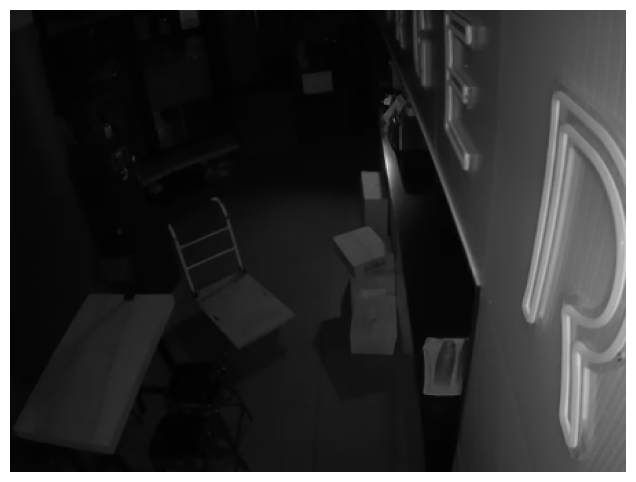


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 한 사람이 벽면 쪽에서 움직이는 모습이 포착되었습니다. 공간에는 의자와 여러 개의 상자들이 놓여있는 것이 보입니다.",
    "person_description": "어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기는 어렵지만, 벽면 근처에서 서있는 형태로 보입니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 한 사람이 벽면 쪽에서 움직이는 모습이 포착되었습니다. 공간에는 의자와 여러 개의 상자들이 놓여있는 것이 보입니다.', 'person_description': '어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기는 어렵지만, 벽면 근처에서 서있는 형태로 보입니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 163
Total tokens: 1212
Latency: 4960 milliseconds
total token usage: {'input': 11535, 'output': 1766, 'total': 13301}


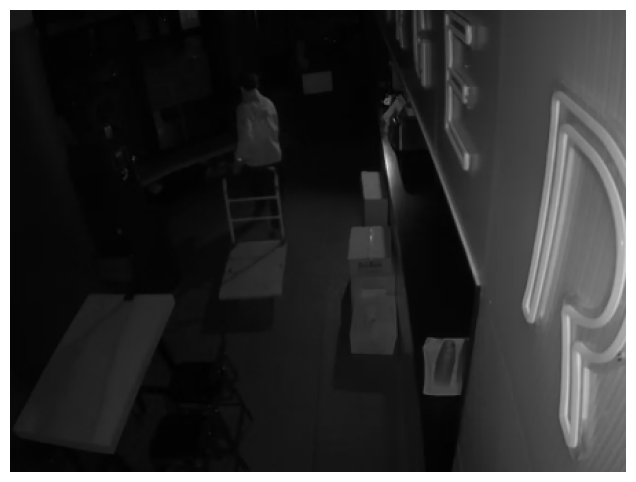


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 한 사람이 사다리를 이용하여 작업을 하고 있습니다. 공간에는 여러 개의 박스나 물체들이 바닥에 배치되어 있습니다.",
    "person_description": "흰색 상의를 입은 사람이 사다리 위에서 무언가 작업을 하고 있습니다. 해당 인물은 벽면을 향해 서있는 자세입니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 한 사람이 사다리를 이용하여 작업을 하고 있습니다. 공간에는 여러 개의 박스나 물체들이 바닥에 배치되어 있습니다.', 'person_description': '흰색 상의를 입은 사람이 사다리 위에서 무언가 작업을 하고 있습니다. 해당 인물은 벽면을 향해 서있는 자세입니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 163
Total tokens: 1212
Latency: 4559 milliseconds
total token usage: {'input': 12584, 'output': 1929, 'total': 14513}


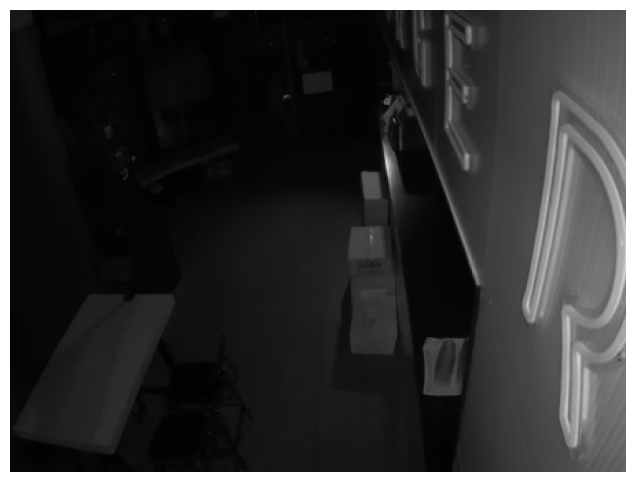


Role: assistant
{
    "scene_description": "어두운 실내 공간에서 한 사람이 움직이고 있습니다. 공간은 매우 어둡고 흑백 CCTV로 촬영되어 있습니다.",
    "person_description": "어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기 어렵습니다. 실루엣 형태로만 관찰됩니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '어두운 실내 공간에서 한 사람이 움직이고 있습니다. 공간은 매우 어둡고 흑백 CCTV로 촬영되어 있습니다.', 'person_description': '어두운 조명 조건으로 인해 사람의 정확한 특징을 파악하기 어렵습니다. 실루엣 형태로만 관찰됩니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 141
Total tokens: 1190
Latency: 5455 milliseconds
total token usage: {'input': 13633, 'output': 2070, 'total': 15703}


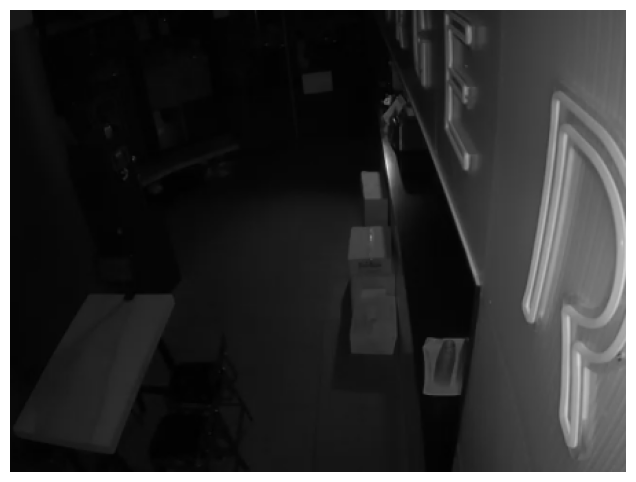


Role: assistant
{
    "scene_description": "실내 공간에서 한 사람이 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 흑백 CCTV로 촬영된 영상입니다.",
    "person_description": "화면이 어둡고 흑백이라 정확한 특징을 파악하기 어렵지만, 한 사람이 공간 내에서 이동하는 것이 관찰됩니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 한 사람이 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 흑백 CCTV로 촬영된 영상입니다.', 'person_description': '화면이 어둡고 흑백이라 정확한 특징을 파악하기 어렵지만, 한 사람이 공간 내에서 이동하는 것이 관찰됩니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 150
Total tokens: 1199
Latency: 3939 milliseconds
total token usage: {'input': 14682, 'output': 2220, 'total': 16902}


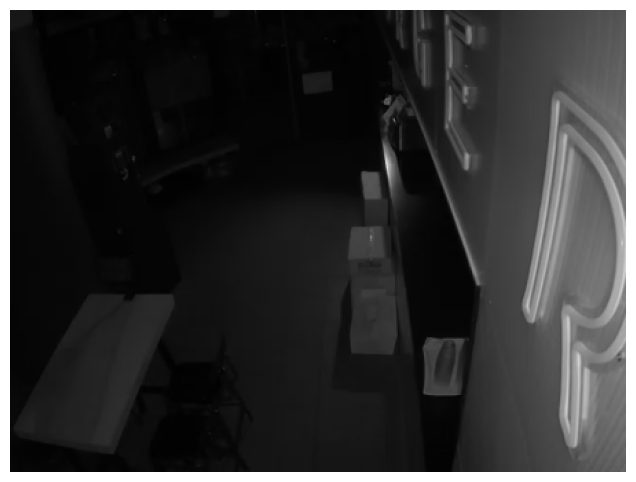


Role: assistant
{
    "scene_description": "실내 공간에서 한 사람이 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 CCTV로 촬영된 영상입니다.",
    "person_description": "어두운 환경으로 인해 정확한 특징을 파악하기는 어렵지만, 한 명의 사람이 실내 공간을 이동하고 있습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 한 사람이 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 CCTV로 촬영된 영상입니다.', 'person_description': '어두운 환경으로 인해 정확한 특징을 파악하기는 어렵지만, 한 명의 사람이 실내 공간을 이동하고 있습니다.'}'
INFO:retry-bedrock-invocation:trying frame_description() [1/5]



Token usage
Input tokens: 1049
Output tokens: 141
Total tokens: 1190
Latency: 4486 milliseconds
total token usage: {'input': 15731, 'output': 2361, 'total': 18092}


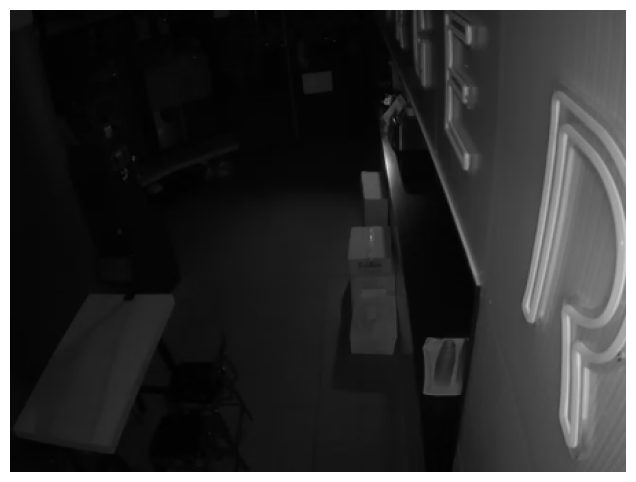


Role: assistant
{
    "scene_description": "실내 공간에서 한 사람이 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 흑백 CCTV로 촬영된 영상입니다.",
    "person_description": "화면 중앙부에서 한 사람이 움직이고 있으나, 어두운 조명으로 인해 정확한 특징을 파악하기 어렵습니다."
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'scene_description': '실내 공간에서 한 사람이 움직이는 모습이 포착되었습니다. 어두운 조명 상태에서 흑백 CCTV로 촬영된 영상입니다.', 'person_description': '화면 중앙부에서 한 사람이 움직이고 있으나, 어두운 조명으로 인해 정확한 특징을 파악하기 어렵습니다.'}'



Token usage
Input tokens: 1049
Output tokens: 144
Total tokens: 1193
Latency: 3782 milliseconds
total token usage: {'input': 16780, 'output': 2505, 'total': 19285}

Role: assistant
{
   "summary": "어두운 실내 공간에서 한 명의 인물이 의심스러운 행동을 보이는 상황입니다. 처음에는 복도를 통해 진입한 후, 상자들이 있는 공간에서 몸을 숙이고 물건을 살펴보는 등의 행동을 보였습니다. 이후 벽면 근처에서 작업하는 듯한 모습을 보이다가 사다리를 이용한 작업을 진행했습니다. 과정에서 의자가 넘어지고 물건들이 흩어지는 상황이 발생했습니다.",

   "key_events": [
       {
           "description": "미상의 인물이 어두운 실내 공간으로 진입",
           "significance": "HIGH"
       },
       {
           "description": "상자들 사이에서 수상한 탐색 행위",
           "significance": "HIGH"
       },
       {
           "description": "의자 전복 및 물건 흩어짐 발생",
           "significance": "HIGH"
       },
       {
           "description": "사다리를 이용한 벽면 작업",
           "significance": "HIGH"
       }
   ],

   "objects_involved": {
       "people": ["단독 행동자 1명"],
       "items": ["상자들", "의자", "사다리", "벽면 물체"]
   },

   "analysis": {
       "pattern": "- 지속적으로 한 명의 인물이 공간을 배회하며 물건을 탐색\n-

In [15]:
analyzer.invoke(
    video_path="./video/video_sample_2.mkv",
    analysis_config={
        "sample_msec": 10000,
        "resize_ratio": 0.7,
        "sample_output_dir": "./workspace"
    }
)

- **approach 2**: n개 연속 프레임 제공 후 상황에 대한 desc를 생성, 생성된 desc를 모아서 요약하여 상황설명 한다.

In [16]:
class video_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=True ## To show token usage
        ) 

        self._graph_definition()
        self.messages = []
        self.img_bytes = ""
        
        self.timer = TimeMeasurement()
        
    def _get_price(self, tokens):
        
        input_price = tokens["input"] * 0.003 / 1000
        output_price = tokens["output"] * 0.015 / 1000
        total = input_price + output_price
        
        print ("======= Cost Calculator =======")
        print (f'Token Usage, input: {tokens["input"]}, Output: {tokens["output"]}')
        print (f'Price: {total} USD')
        print ("===============================")
        
    def _get_string_from_message(self, message):
        return message["content"][0]["text"]
    
    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": [{"text": dedent(string)}]
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)

        return message
    
    def _frame_to_bytes(self, frame, format='.png'):
        """
        cv2 frame을 bytes로 변환

        Args:
            frame: cv2로 읽은 이미지/프레임
            format: 이미지 포맷 (예: '.jpg', '.png')

        Returns:
            bytes: 이미지의 바이트 데이터
        """
        # imencode() 함수로 프레임을 지정된 포맷의 이미지로 인코딩
        # 반환값: (success, encoded_image)
        success, buffer = cv2.imencode(format, frame)

        if not success:
            raise ValueError("이미지 인코딩 실패")

        # numpy array를 bytes로 변환
        return buffer.tobytes()

    def _save_pickle(self, data: Any, file_path: str | Path) -> None:
        """
        데이터를 pickle 파일로 저장합니다.

        Args:
            data: 저장할 데이터 (Any type)
            file_path: 저장할 파일 경로 (확장자 .pkl 권장)
        """
        file_path = Path(file_path)

        # 디렉토리가 없으면 생성
        file_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with open(file_path, 'wb') as f:
                pickle.dump(data, f)
            print(f"Successfully saved to {file_path}")
        except Exception as e:
            print(f"Error saving pickle file: {e}")

    def _load_pickle(self, file_path: str | Path) -> Any:
        """
        pickle 파일을 로드합니다.

        Args:
            file_path: 로드할 파일 경로

        Returns:
            저장된 데이터 객체

        Raises:
            FileNotFoundError: 파일이 존재하지 않을 경우
        """
        file_path = Path(file_path)

        if not file_path.exists():
            raise FileNotFoundError(f"No pickle file found at {file_path}")

        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            return data
        except Exception as e:
            print(f"Error loading pickle file: {e}")
            return None

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):
        
        def agent(state):
            
            self.timer.start()
            self.timer.reset()
            
            print("---CALL AGENT---")
            video_path = state["video_path"]
            analysis_config = state["analysis_config"]
            
            self.tokens = {"input": 0, "output": 0, "total": 0}
            self.pricing = {"input": 0, "output": 0}
            
            print (analysis_config)
 
            return self.state(
                video_path=video_path,
                analysis_config=analysis_config,
                rev_node="AGENT"
            )

        def sample_video_frames(state):
        
            def setup_directory(dir_path):
    
                print ("===setup_directory===")
                # 디렉토리가 존재하는지 확인
                if os.path.exists(dir_path):
                    # 존재하면 삭제
                    shutil.rmtree(dir_path)
                    print(f"기존 디렉토리 삭제됨: {dir_path}")

                # 디렉토리 생성
                os.makedirs(dir_path)
                print(f"디렉토리 생성됨: {dir_path}")
                print ("=====================")
    
            video_path = state["video_path"]
            sample_msec = state["analysis_config"]["sample_msec"]
            resize_ratio = state["analysis_config"]["resize_ratio"]
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            print("---SAMPLE VIDEO FRAMES---")
            """
            비디오에서 특정 시간 간격으로 프레임을 샘플링하는 함수

            Args:
                video_path (str): 비디오 파일 경로
                sample_msec (int): 샘플링 간격 (밀리초)
                sample_output_dir (Optional[str]): 프레임 저장 디렉토리. None이면 저장하지 않음

            Returns:
                Tuple[int, int]: (총 프레임 수, 샘플링된 프레임 수)

            Raises:
                FileNotFoundError: 비디오 파일이 없는 경우
                ValueError: 샘플링 간격이 잘못된 경우
            """
            # 입력값 검증
            if not os.path.exists(video_path):
                raise FileNotFoundError(f"비디오 파일을 찾을 수 없습니다: {video_path}")

            if sample_msec <= 0:
                raise ValueError("샘플링 간격은 0보다 커야 합니다")

            # 비디오 캡처 객체 생성
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise RuntimeError("비디오 파일을 열 수 없습니다")

            # 비디오 정보 가져오기
            fps = cap.get(cv2.CAP_PROP_FPS)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # 샘플링 간격(프레임 단위) 계산
            frame_interval = max(1, int(sample_msec / 1000 * fps))

            # 출력 디렉토리 생성 (지정된 경우)
            if sample_output_dir is not None:
                setup_directory(sample_output_dir)

            sampled_count = 0
            frame_count = 0
            sampled_frame = {"frame": [], "seq": []}

            while True:
                ret, frame = cap.read()
                if not ret: break
                
                # resize
                if resize_ratio != 1:
                    re_width, re_height = int(frame.shape[1]*resize_ratio), int(frame.shape[0]*resize_ratio)
                    frame = cv2.resize(frame, (re_width, re_height), interpolation=cv2.INTER_AREA)

                # frame_interval마다 프레임 처리
                if frame_count % frame_interval == 0:
                    if sample_output_dir is not None:
                        # 프레임 저장
                        frame_path = os.path.join(sample_output_dir, f"frame_{frame_count:06d}.jpg")
                        cv2.imwrite(frame_path, frame)
                    sampled_count += 1
                    sampled_frame["frame"].append(frame)
                    sampled_frame["seq"].append(frame_count)
                frame_count += 1

                # 진행상황 출력 (10% 단위)
                if frame_count % (total_frames // 10) == 0:
                    progress = (frame_count / total_frames) * 100
                    print(f"진행률: {progress:.1f}%")

            # 자원 해제
            cap.release()

            print(f"\n처리 완료:")
            print(f"총 프레임 수: {total_frames}")
            print(f"프레임 크기: {sampled_frame['frame'][0].shape[1]}X{sampled_frame['frame'][0].shape[0]}")
            print(f"샘플링된 프레임 수: {sampled_count}")
            print(f"샘플링 간격: {frame_interval}프레임 ({sample_msec}ms)")
            if sample_output_dir is not None:
                print(f"저장 위치: {sample_output_dir}")

            print ("=========================")
            
            sampled_frames_path = os.path.join(sample_output_dir, "pickle", "sampled_frames.pickle")
            self._save_pickle(sampled_frame, sampled_frames_path)
            
            video_info = {
                "sampled_frames_path": sampled_frames_path,
                "total_frame_cnt": total_frames,
                "sampled_cnt": sampled_count
            }
            
            self.timer.measure("node: sample_video_frames")
            self.timer.print_measurements()
            
            return self.state(
                video_info=video_info,
                rev_node="SAMPLE_VIDEO_FRAMES"
            )
        
        def video_description(state):
            
            @retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
            def frame_description(**kwargs):
    
                sampled_frame = kwargs["sampled_frame"]
                sampled_frame_idx = kwargs["sampled_frame_idx"]
                frame_batch_size = kwargs["frame_batch_size"]
                prev_frame_desc = kwargs.get("prev_frame_desc", "None")
                messages = kwargs["messages"]

                system_prompts = dedent(
                    '''
                    당신은 CCTV 영상 분석 전문가입니다.
                    연속된 n개의 CCTV 프레임 이미지를 분석하고 전체 상황을 자연어로 설명하는 것이 당신의 임무입니다.

                    <task>
                    연속된 CCTV 프레임들을 관찰하여 전체 시퀀스에서 발생하는 상황을 자연어로 설명
                    </task>

                    <input>
                    1. frames: CCTV에서 캡처된 n개의 연속된 프레임 이미지들
                    2. frame_count: 제공된 프레임의 수
                    3. prev_frame_desc: 이전 프레임셋의 상황 설명
                    </input>

                    <output_format>
                    {
                       "sequence_summary": "전체 시퀀스에서 관찰되는 상황에 대한 객관적 설명",
                       "key_events": [
                           {
                               "frame_range": [시작_프레임, 종료_프레임],
                               "event_description": "주요 이벤트 설명"
                           }
                       ]
                    }
                    </output_format>

                    <instruction>
                    1. 프레임들을 연속성을 검토하고 그 속에서 물체/사람의 움직임을 파악하세요.
                    2. 이전 상황 설명을 참고하여 상황의 연속성을 파악하세요.
                    3. 동일 사람 여부 및 사람 수 보다는 행동 및 상황 설명에 집중하세요.
                    3. 움직임이 없는 물체/사람에 대해서는 설명하지 마세요.
                    4. 주변 사물에 대해서는 설명하지 마세요.
                    5. 특이사항이나 중요한 변화가 있다면 이를 강조하세요.
                    6. 추측이나 주관적 해석은 최소화하고 관찰 가능한 사실만 설명하세요.
                    7. 설명은 간결하고 명확하게 작성하세요.
                    8. 설명은 한글로 작성하세요.
                    </instruction>

                    <consideration>
                    1. 주어진 프레임들은 시간 순서대로 나열되어 있습니다.
                    1. 사람이나 물체의 위치 변화에 특히 주의를 기울이세요.
                    2. 시야가 가려지거나 불명확한 부분이 있다면 이를 명시하세요.
                    3. 사람 구분 보다는 행위에 집중해서 설명하세요.
                    4. 비정상적이거나 특이한 활동이 관찰되면 이를 강조하세요.
                    5. 조명 상태나 화질로 인한 제약사항이 있다면 이를 언급하세요.
                    6. 한 사람이 시야에서 사라졌다가 다시 나타나는 경우, 동일 인물임을 파악하여 설명하세요.
                    </consideration>

                    '''
                )
                user_prompts = dedent(
                    '''
                    This is <frame_count>{frame_count}</frame_count>
                    This is <prev_frame_desc>{prev_frame_desc}</prev_frame_desc>
                    This is the frame.

                    '''
                )

                img_bytes = []
                for frame in sampled_frame:                    
                    img_bytes.append(self._frame_to_bytes(frame))
                
                system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

                context = {
                    "frame_count": sampled_frame_idx,
                    "prev_frame_desc": prev_frame_desc
                }
                user_prompts = user_prompts.format(**context)

                message = self._get_message_from_string(role="user", string=user_prompts, imgs=img_bytes)
                messages.append(message)
                
                # 이미지 표시
                num_frames = len(sampled_frames)
                num_cols = frame_batch_size #5 # row에 몇개의 사진을 보이게 할 것 인가
                num_rows = (num_frames + num_cols - 1) // num_cols  # 올림 나눗셈

                # 전체 figure 크기 설정
                plt.figure(figsize=(4*num_cols, 4*num_rows))

                # 각 프레임을 subplot으로 표시
                for idx, frame in enumerate(sampled_frame):
                    plt.subplot(num_rows, num_cols, idx + 1)

                    # BGR to RGB 변환
                    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    # 이미지 표시
                    plt.imshow(rgb_frame)
                    plt.title(f'Frame {idx+1}')
                    plt.axis('off')

                # subplot 간 간격 조정
                plt.tight_layout()
                plt.show()
                
                ## Call LLM
                resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
                messages = messages_updated
                results = eval(resp["text"])
                
                if self.llm_caller.verbose:
                    self.tokens["input"] += resp["token_usage"]["inputTokens"]
                    self.tokens["output"] += resp["token_usage"]["outputTokens"]
                    self.tokens["total"] += resp["token_usage"]["totalTokens"]
                    print (f'total token usage: {self.tokens}')    

                return results
            
            print("---VIDEO DESCRIPTION---")
            
            frame_batch_size = state["analysis_config"]["frame_numbers_at_one"] 
            sliding_interval = state["analysis_config"]["sliding_window_size"] 
            sampled_frames= self._load_pickle(state["video_info"]["sampled_frames_path"])
            total_frame_cnt=state["video_info"]["total_frame_cnt"]
            total_sample_frame_cnt = state["video_info"]["sampled_cnt"]
            messages=kwargs.get("messages", [])
            
            # 제약 조건 체크
            if frame_batch_size > total_sample_frame_cnt:
                raise ValueError("Window size cannot be larger than total frames")

            # 마지막 프레임까지 커버하기 위한 조건 체크
            remaining_frames = (total_sample_frame_cnt - frame_batch_size) % sliding_interval
            if remaining_frames != 0:
                print(f"Warning: Last {remaining_frames} frames might be skipped with current parameters")
                print(f"Recommended sliding_interval: {[i for i in range(1, frame_batch_size) if (total_sample_frame_cnt - frame_batch_size) % i == 0]}")
                #raise ValueError("In this settingm you could not use all frames. Read recommendations")

            # 마지막 시작점 계산
            last_start = total_sample_frame_cnt - frame_batch_size

            frame_desc = "None"
            frame_descs = []
            for i in range(0, last_start + 1, sliding_interval):
                # frame_batch_size 개의 연속된 프레임 슬라이스 추출
                sampled_frame_idx = sampled_frames["seq"][i:i+frame_batch_size]
                sampled_frame = sampled_frames["frame"][i:i+frame_batch_size]

                # 마지막 윈도우가 전체 프레임을 커버하지 못하는 경우, 마지막 윈도우 추가
                # if i + sliding_interval > last_start and i != last_start:
                #     sampled_frame_idx = sampled_frames["seq"][last_start:last_start+frame_batch_size]
                #     sampled_frame = sampled_frames["frame"][last_start:last_start+frame_batch_size]
                    #break
                
                res = frame_description(
                    sampled_frame=sampled_frame,
                    sampled_frame_idx=sampled_frame_idx,
                    frame_batch_size=frame_batch_size,
                    total_frame_cnt=total_frame_cnt,
                    frame_desc=frame_desc, 
                    messages=[]
                )

                frame_desc = res["sequence_summary"]
                frame_descs.append(res["sequence_summary"])


            system_prompts = dedent(
                '''
                당신은 CCTV 영상의 전체 상황을 분석하는 전문가입니다.
                개별 프레임 설명들을 종합하여 전체 시퀀스에서 발생한 상황을 요약하고 의미있는 이벤트를 추출하는 것이 당신의 임무입니다.

                <task>
                시간 순서대로 정렬된 프레임별 설명을 분석하여 전체 상황을 요약하고 중요 이벤트를 추출
                </task>

                <input>
                - frame_descriptions: 각 프레임별 설명(상황 설명)이 담긴 텍스트형태의 리스트
                </input>

                <output_format>
                {
                   "summary": "전체 시퀀스에서 발생한 상황에 대한 종합적 설명",
                   "key_events": [
                       {
                           "description": "이벤트 설명",
                           "significance": "이벤트의 중요도 (HIGH/MEDIUM/LOW)"
                       }
                   ],
                   "objects_involved": {
                       "people": ["식별된 사람 수 및 역할"],
                       "items": ["관련된 주요 물체들"]
                   },
                   "analysis": {
                       "pattern": "발견된 행동 패턴",
                       "anomalies": ["비정상적인 활동이나 특이사항"],
                       "risk_assessment": "잠재적 위험 평가"
                   }
                }
                </output_format>

                <instruction>
                1. 개별 프레임 설명들을 시간순으로 검토하여 전체 맥락을 파악하세요.
                2. 전체적인 맥락을 고려하여 프레임 설명이 잘못되어 있다면 수정하여 결과에 반영하세요.
                3. 프레임 설명은 하나의 상황을 반영하고 있음을 인지하세요.
                4. 연속된 프레임들에서 의미있는 이벤트를 식별하세요.
                5. 이벤트의 중요도를 평가할 때는 다음을 고려하세요:
                  - 보안상의 위험성
                  - 비정상적인 행동 패턴
                  - 시설물이나 재산에 대한 위험
                6. 전체 상황에서 패턴이나 특이사항을 분석하세요.
                7. 설명은 간결하고 객관적으로 작성하세요.
                8. 설명은 한글로 작성하세요.
                </instruction>

                <consideration>
                1. 단순한 움직임이나 일상적인 활동은 중요 이벤트에서 제외하세요.
                2. 동일한 이벤트가 반복되는 경우 패턴으로 분류하세요.
                3. 시간대별 일반적인 활동 패턴과 비교하여 이상 징후를 판단하세요.
                4. 보안과 프라이버시를 고려하여 개인을 특정할 수 있는 정보는 제외하세요.
                5. 불확실한 상황에 대해서는 추측을 피하고 관찰된 사실만 보고하세요.
                6. 잠재적 위험이 감지되면 이를 반드시 포함하세요.
                7. 전체 맥락에서 중요하지 않은 세부사항은 생략하세요.
                8. 움직이는 사람 설명을 바탕으로 frame에 등장하는 사람의 동일인 여부를 판단하세요.
                </consideration>
                '''
            )
            user_prompts = dedent(
                '''
                This is <frame_descriptions>{frame_descriptions}</frame_descriptions>

                '''
            )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)  

            context = {
                "frame_descriptions": str(frame_descs)
            }
            user_prompts = user_prompts.format(**context)

            message = self._get_message_from_string(role="user", string=user_prompts)
            messages.append(message)

            resp, messages_updated = self.llm_caller.invoke(messages=messages, system_prompts=system_prompts)
            messages = messages_updated
            results = eval(resp["text"])
            
            if self.llm_caller.verbose:
                self.tokens["input"] += resp["token_usage"]["inputTokens"]
                self.tokens["output"] += resp["token_usage"]["outputTokens"]
                self.tokens["total"] += resp["token_usage"]["totalTokens"]            
                self._get_price(self.tokens)
            
            self.timer.measure("node: video_description")
            self.timer.print_measurements()
            
            return self.state(
                summary=results,
                rev_node="VIDEO_DESCRIPTION"
            )
        
        def cleanup(state):
                        
            print("---CLEAN UP---")
            sample_output_dir = state["analysis_config"]["sample_output_dir"]
            
            if os.path.exists(sample_output_dir):
                # 존재하면 삭제
                shutil.rmtree(sample_output_dir)
                print(f"디렉토리 삭제됨: {sample_output_dir}")
                        
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("agent", agent)  # 에이전트 노드를 추가합니다.
        workflow.add_node("sample_video_frames", sample_video_frames)  # 비디오를 샘플링하여 프레임(이미지)변환 노드를 추가합니다.
        workflow.add_node("video_description", video_description)  # 비디오 영상 설명 노드를 추가합니다.
        workflow.add_node("cleanup", cleanup)  # 정리 노드를 추가합니다.

        workflow.add_edge("agent", "sample_video_frames")
        workflow.add_edge("sample_video_frames", "video_description")
        workflow.add_edge("video_description", "cleanup")
        workflow.add_edge("cleanup", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("agent")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "VideoAnalysis"})

    def invoke(self, **kwargs):
        
        inputs = self.state(
            video_path=kwargs["video_path"],
            analysis_config=kwargs["analysis_config"]
        )
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint(f"\nOutput from node '{key}':")
                pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint("\n---\n")
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [17]:
analyzer = video_analyzer(
    llm=llm
)

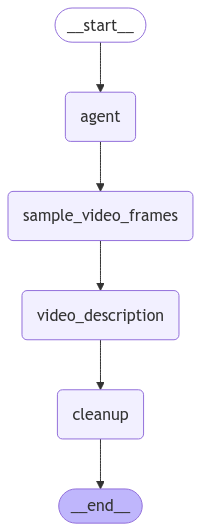

In [18]:
analyzer.show_graph()

---CALL AGENT---
{'sample_msec': 8000, 'resize_ratio': 0.7, 'frame_numbers_at_one': 7, 'sliding_window_size': 7, 'sample_output_dir': './workspace'}
"\nOutput from node 'agent':"
'---'
{ 'analysis_config': { 'frame_numbers_at_one': 7,
                       'resize_ratio': 0.7,
                       'sample_msec': 8000,
                       'sample_output_dir': './workspace',
                       'sliding_window_size': 7},
  'video_path': './video/video_sample_3.mkv'}
'\n---\n'
---SAMPLE VIDEO FRAMES---
===setup_directory===
기존 디렉토리 삭제됨: ./workspace
디렉토리 생성됨: ./workspace
진행률: 10.0%
진행률: 19.9%
진행률: 29.9%
진행률: 39.8%
진행률: 49.8%
진행률: 59.8%
진행률: 69.7%
진행률: 79.7%


INFO:retry-bedrock-invocation:trying frame_description() [1/5]


진행률: 89.7%

처리 완료:
총 프레임 수: 1546
프레임 크기: 448X336
샘플링된 프레임 수: 7
샘플링 간격: 242프레임 (8000ms)
저장 위치: ./workspace
Successfully saved to workspace/pickle/sampled_frames.pickle

elapsed time: node: sample_video_frames: 1.93359 초
"\nOutput from node 'sample_video_frames':"
'---'
{ 'video_info': { 'sampled_cnt': 7,
                  'sampled_frames_path': './workspace/pickle/sampled_frames.pickle',
                  'total_frame_cnt': 1546}}
'\n---\n'
---VIDEO DESCRIPTION---


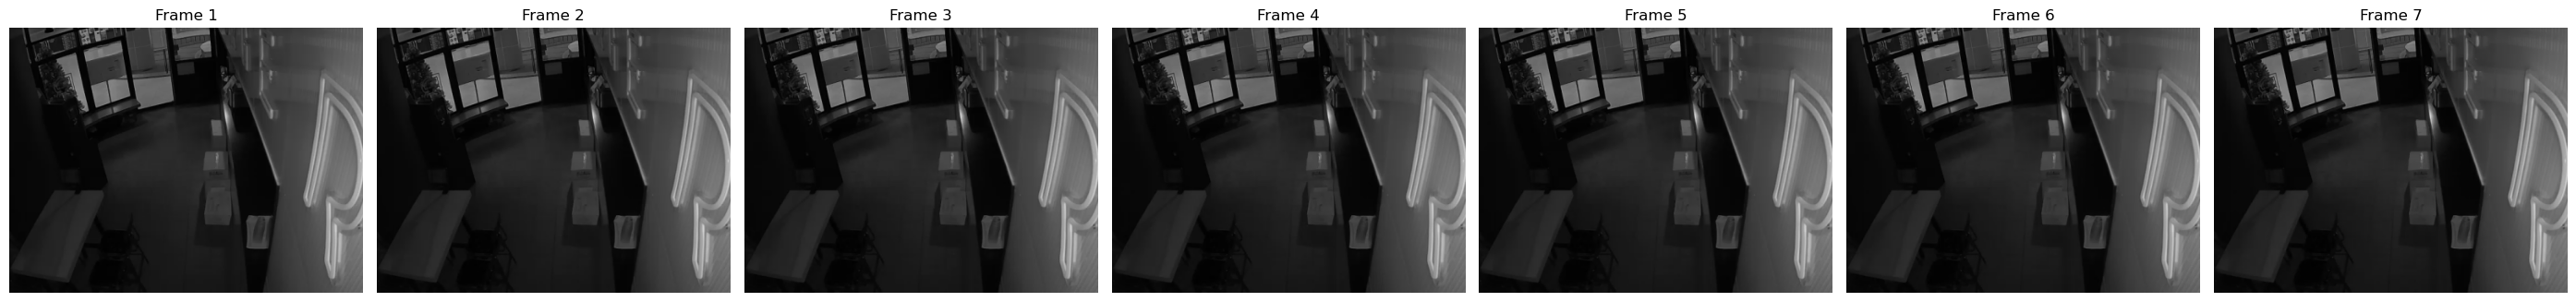


Role: assistant
{
    "sequence_summary": "실내 공간에서 특별한 움직임이나 활동이 관찰되지 않는 정적인 상황입니다. 카메라는 출입구가 보이는 복도나 통로를 비추고 있으며, 시간 경과 동안 특이사항은 발생하지 않았습니다.",
    "key_events": [
        {
            "frame_range": [0, 1452],
            "event_description": "전체 프레임 동안 움직임이나 특이사항 없음"
        }
    ]
}

INFO:retry-bedrock-invocation:in retry(), frame_description() returned '{'sequence_summary': '실내 공간에서 특별한 움직임이나 활동이 관찰되지 않는 정적인 상황입니다. 카메라는 출입구가 보이는 복도나 통로를 비추고 있으며, 시간 경과 동안 특이사항은 발생하지 않았습니다.', 'key_events': [{'frame_range': [0, 1452], 'event_description': '전체 프레임 동안 움직임이나 특이사항 없음'}]}'



Token usage
Input tokens: 2331
Output tokens: 175
Total tokens: 2506
Latency: 5736 milliseconds
total token usage: {'input': 2331, 'output': 175, 'total': 2506}

Role: assistant
{
    "summary": "실내 공간(복도/통로)의 출입구를 촬영한 CCTV 영상으로, 해당 시간 동안 어떠한 인적 활동이나 특이사항도 관찰되지 않은 정적인 상황입니다.",
    
    "key_events": [
        {
            "description": "특이사항 없음",
            "significance": "LOW"
        }
    ],
    
    "objects_involved": {
        "people": ["없음"],
        "items": ["출입구", "복도/통로"]
    },
    
    "analysis": {
        "pattern": "정적인 상태 유지",
        "anomalies": ["없음"],
        "risk_assessment": "현재 특별한 위험 요소 없음"
    }
}
Token usage
Input tokens: 1192
Output tokens: 236
Total tokens: 1428
Latency: 6040 milliseconds
======= Cost Calculator =======
Token Usage, input: 3523, Output: 411
Price: 0.016734 USD

elapsed time: node: sample_video_frames: 1.93359 초

elapsed time: node: video_description: 12.41355 초
"\nOutput from node 'video_description':"
'---'
{ 'summary': { 'analysis'

In [25]:
analyzer.invoke(
    video_path="./video/video_sample_2.mkv",
    analysis_config={
        "sample_msec": 10000, ## 샘플링 시간 (ms)
        "resize_ratio": 0.7, ## 이미지 크기 변환 비율
        "frame_numbers_at_one": 7, ## 한번에 분석할 이미지 수
        "sliding_window_size": 7, ## 다음 분석을 위해 건너 뛸 이미지 수
        "sample_output_dir": "./workspace"
    }
)


In [ ]:
import cv2
import matplotlib.pyplot as plt

- cv2.CAP_PROP_FPS: 초당 프레임 수
- cv2.CAP_PROP_FRAME_COUNT: 총 프레임 수
- cv2.CAP_PROP_FRAME_WIDTH: 프레임 너비
- cv2.CAP_PROP_FRAME_HEIGHT: 프레임 높이
- cv2.CAP_PROP_POS_FRAMES: 현재 프레임 번호
- cv2.CAP_PROP_POS_MSEC: 현재 위치(밀리초)
- cv2.CAP_PROP_FOURCC: 비디오 코덱
- cv2.CAP_PROP_BRIGHTNESS: 밝기
- cv2.CAP_PROP_CONTRAST: 대비